## Player Clustering (In this part I also used chatGPT's help)

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Set pandas to display all columns
pd.set_option('display.max_columns', None)

# Load the dataset
data = pd.read_csv('enriched_high_elo_games.csv')

# Select features for clustering
features = [
    'white_elo',
    'white_total_wins',
    'white_total_losses',
    'eco',
    'termination'
]

# Create a player-level dataset by aggregating unique White players
player_data = data[features + ['white']].drop_duplicates(subset=['white'])

# Filter eco to top 10 most frequent codes
top_eco = player_data['eco'].value_counts().head(10).index
player_data['eco'] = player_data['eco'].where(player_data['eco'].isin(top_eco), 'other')

# Handle missing values and impute 0s with median for total wins/losses
for col in ['white_total_wins', 'white_total_losses']:
    median_value = player_data[player_data[col] != 0][col].median()
    player_data[col] = player_data[col].replace(0, median_value)
    player_data[col] = player_data[col].fillna(median_value)

# Impute missing white_elo with median
player_data['white_elo'] = player_data['white_elo'].fillna(player_data['white_elo'].median())

# Impute missing categorical values with mode
for col in ['eco', 'termination']:
    player_data[col] = player_data[col].fillna(player_data[col].mode()[0])

# Encode categorical variables
player_data = pd.get_dummies(player_data, columns=['eco', 'termination'], drop_first=True)

# Drop the 'white' column
player_data = player_data.drop(columns=['white'])

# Standardize numerical features
numerical_cols = ['white_elo', 'white_total_wins', 'white_total_losses']
scaler = StandardScaler()
player_data[numerical_cols] = scaler.fit_transform(player_data[numerical_cols])

## Determine optimal number of clusters using elbow method

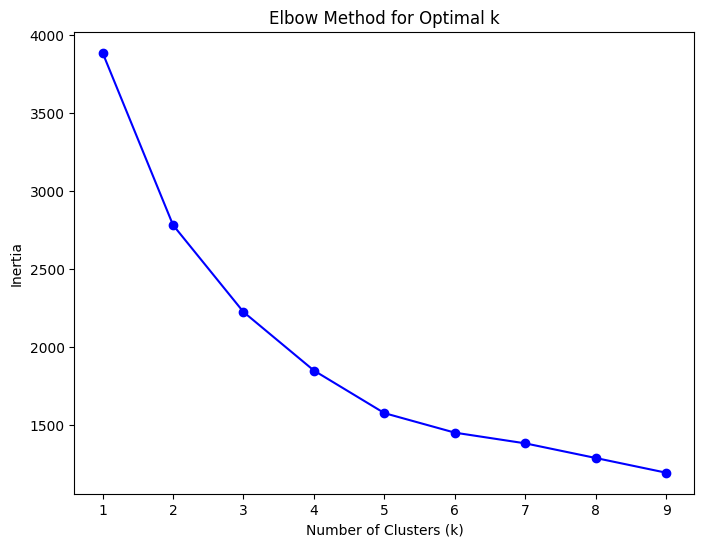

In [2]:
inertia = []
K = range(1, 10)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(player_data)
    inertia.append(kmeans.inertia_)

# Plot elbow curve (to screen)
plt.figure(figsize=(8, 6))
plt.plot(K, inertia, 'bo-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.show()

### Apply k-means with chosen number of clusters & Reduce dimensions for visualization using PCA

In [3]:
kmeans = KMeans(n_clusters=4, random_state=42)
player_data['cluster'] = kmeans.fit_predict(player_data)


pca = PCA(n_components=2)
pca_result = pca.fit_transform(player_data.drop(columns=['cluster']))
player_data['pca1'] = pca_result[:, 0]
player_data['pca2'] = pca_result[:, 1]

## Visualize clusters and Analyze 

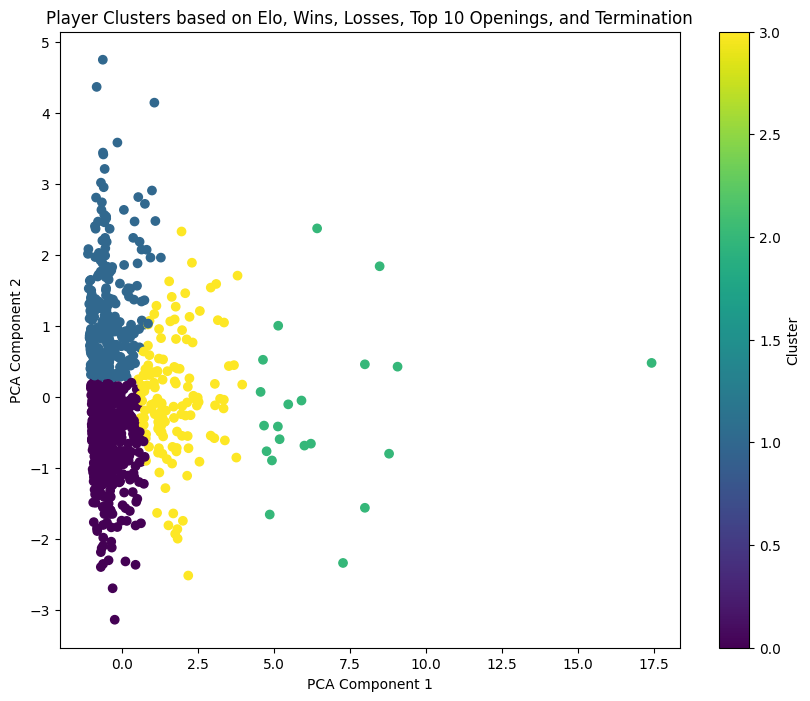

Cluster Summary:
         white_elo  white_total_wins  white_total_losses   eco_A04   eco_A40  \
cluster                                                                        
0        -0.552186         -0.341979           -0.316665  0.014440  0.034296   
1         1.127031         -0.229572           -0.312458  0.055363  0.038062   
2        -0.481850          4.512859            4.966376  0.000000  0.000000   
3        -0.071191          1.184063            1.187049  0.022059  0.066176   

          eco_A45   eco_B00   eco_B01   eco_B07   eco_B21   eco_C00   eco_D00  \
cluster                                                                         
0        0.021661  0.021661  0.034296  0.021661  0.016245  0.048736  0.016245   
1        0.013841  0.013841  0.031142  0.020761  0.027682  0.031142  0.013841   
2        0.000000  0.000000  0.095238  0.047619  0.000000  0.047619  0.047619   
3        0.022059  0.014706  0.014706  0.022059  0.014706  0.051471  0.036765   

         eco_ot

In [4]:
plt.figure(figsize=(10, 8))
scatter = plt.scatter(player_data['pca1'], player_data['pca2'], c=player_data['cluster'], cmap='viridis')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('Player Clusters based on Elo, Wins, Losses, Top 10 Openings, and Termination')
plt.colorbar(scatter, label='Cluster')
plt.show()

# Cluster characteristics
cluster_summary = player_data.groupby('cluster').mean()
print("Cluster Summary:")
print(cluster_summary)

# Print column names for reference
print("Columns in cluster_summary:")
print(cluster_summary.columns.tolist())

# Cluster Summary Analysis (High Elo Players)

This section analyzes clusters generated from a **high-Elo player** dataset using standardized features such as Elo rating, win/loss stats, ECO opening codes, and game termination types.

---

## Cluster Overview and Interpretation

### **Cluster 0 – Solid but Conservative High-Elo Players**
- **White Elo**: -0.55 → Slightly below mean of high-Elo group
- **Wins/Losses**: Modestly below average
- **Openings**: Moderate variety, slight lean toward C and B-series (e.g., B01, C00)
- **Termination**:
  - Normal: 0.69
  - Time forfeit: 0.31
- **PCA Components**:
  - `pca1`: -0.44
  - `pca2`: -0.58
- **Interpretation**:  
  Stable, methodical high-Elo players. They finish games cleanly and rely on established openings but are slightly underperforming in terms of results.

---

### **Cluster 1 – Technically Elite but Risky**
- **White Elo**: 1.13 → **Highest Elo**
- **Wins/Losses**: Slightly negative overall
- **Openings**: Diverse across A, B, C series with a clear grasp of theory
- **Termination**:
  - Normal: 0.63
  - Time forfeit: 0.37
- **PCA Components**:
  - `pca1`: -0.44
  - `pca2`: 1.11 (very distinct)
- **Interpretation**:  
  High-level players using refined strategy. Their win/loss counts don't show dominance, but their opening variety and PCA suggest elite play with complex positions and longer games.

---

### **Cluster 2 – Power Players**
- **White Elo**: -0.48 → Slightly below average for this band
- **Wins**: 4.51, **Losses**: 4.97 → **Extremely high activity**
- **Openings**: Focused on B01, B07, C00, D00
- **Termination**:
  - Normal: 0.57
  - Time forfeit: 0.43
- **PCA Components**:
  - `pca1`: 6.72 → Extreme
  - `pca2`: -0.18
- **Interpretation**:  
  Aggressive, high-volume players. Likely tactical fighters playing a lot of games quickly. Their Elo may not reflect true skill due to high loss count, but volume is unmatched.

---

### **Cluster 3 – Strategic and Consistent Performers**
- **White Elo**: -0.07 → Close to the average
- **Wins/Losses**: 1.18 / 1.19 → Balanced and controlled
- **Openings**: Mix of C00, D00, A40 — theory-driven selections
- **Termination**:
  - Normal: 0.56
  - Time forfeit: 0.43
- **PCA Components**:
  - `pca1`: 1.68
  - `pca2`: 0.01
- **Interpretation**:  
  Consistent, methodical players with strong knowledge of theory. May be positional specialists focused on quality over quantity. Solid mid-to-upper tier in high-Elo brackets.

---

## Summary Table

| Cluster | Summary Description            | Key Features                                                  |
|---------|--------------------------------|---------------------------------------------------------------|
| 0       | Solid conservative players     | Slightly underperforming, clean finishes, safe strategies     |
| 1       | Elite, technical, risky        | Highest Elo, diverse openings, standout PCA2, complex style   |
| 2       | Aggressive power users         | Highest win/loss activity, tactical and fast-paced games      |
| 3       | Balanced strategic performers  | Consistent, mid-high Elo, focused openings, controlled play   |

---